In [1]:
import numpy as np
import pandas as pd
from statannotations.Annotator import Annotator
from scipy.stats import wilcoxon

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
os.chdir("../Figure3")

In [4]:
np.random.seed(42)

In [5]:
PHYLA = ['Annelida', 'Arthropoda', 'Chordata', 'Cnidaria', 'Echinodermata', 'Mollusca', 'Nematoda', 'Platyhelminthes']
RANKS = ['class', 'order', 'family', 'genus', 'species']

# DeepCOI

In [6]:
deepcoi = pd.read_csv("DeepCOI/DeepCOI.scores.csv")
deepcoi['method'] = 'DeepCOI'
deepcoi.head(n=2)

,phylum,rank,AUROC,AUPR,method
0,Platyhelminthes,class,0.963184,0.949971,DeepCOI
1,Cnidaria,class,0.997853,0.996128,DeepCOI


# RDP

In [7]:
rdp = pd.read_csv("RDP/RDP.scores.csv")
rdp['method'] = 'RDP'
rdp.head(n=2)

,phylum,rank,AUROC,AUPR,method
0,Annelida,class,0.941135,0.889151,RDP
1,Arthropoda,class,0.996404,0.918005,RDP


# BLAST

In [8]:
blast = pd.read_csv("BLAST/BLAST.scores.csv")
blast['method'] = 'BLASTn'
blast.head(n=2)

,phylum,rank,AUROC,AUPR,method
0,Annelida,class,0.889431,0.86684,BLASTn
1,Arthropoda,class,0.985246,0.97798,BLASTn


# Figure3

In [9]:
df = pd.concat([deepcoi, rdp, blast])
df['phylum'] = pd.Categorical(df['phylum'], ordered=True, categories=PHYLA)
df['rank'] = pd.Categorical(df['rank'], ordered=True, categories=RANKS)
df = df.sort_values(['rank', 'phylum'])

In [10]:
roc_std, pr_std = [], []
for method in ["DeepCOI", 'RDP', 'BLASTn']:
    roc_std.append(df.query("method == @method").groupby('rank')['AUROC'].std().values)
    pr_std.append(df.query("method == @method").groupby('rank')['AUPR'].std().values)
roc_std = np.concatenate(roc_std)
pr_std = np.concatenate(pr_std)

# Statistical Test

In [11]:
roc_pairs, pr_pairs = [], []
for rank in RANKS:
    for method in ['RDP', 'BLASTn']:
        stats = wilcoxon(
            df.query("method == 'DeepCOI' and rank == @rank")['AUROC'],
            df.query("method == @method and rank == @rank")['AUROC']
        )

        if stats.pvalue < 0.05:
            roc_pairs.append(((rank, 'DeepCOI'), (rank, method)))
            
for rank in RANKS:
    for method in ['RDP', 'BLASTn']:
        stats = wilcoxon(
            df.query("method == 'DeepCOI' and rank == @rank")['AUPR'],
            df.query("method == @method and rank == @rank")['AUPR']
        )
        
        if stats.pvalue < 0.05:
            pr_pairs.append(((rank, 'DeepCOI'), (rank, method)))

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

family_DeepCOI vs. family_RDP: Wilcoxon test (paired samples), P_val:3.906e-02 Stat=3.000e+00
genus_DeepCOI vs. genus_RDP: Wilcoxon test (paired samples), P_val:1.562e-02 Stat=1.000e+00
species_DeepCOI vs. species_RDP: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
order_DeepCOI vs. order_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
family_DeepCOI vs. family_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
genus_DeepCOI vs. genus_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
species_DeepCOI vs. species_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
class_DeepCOI vs. class_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02

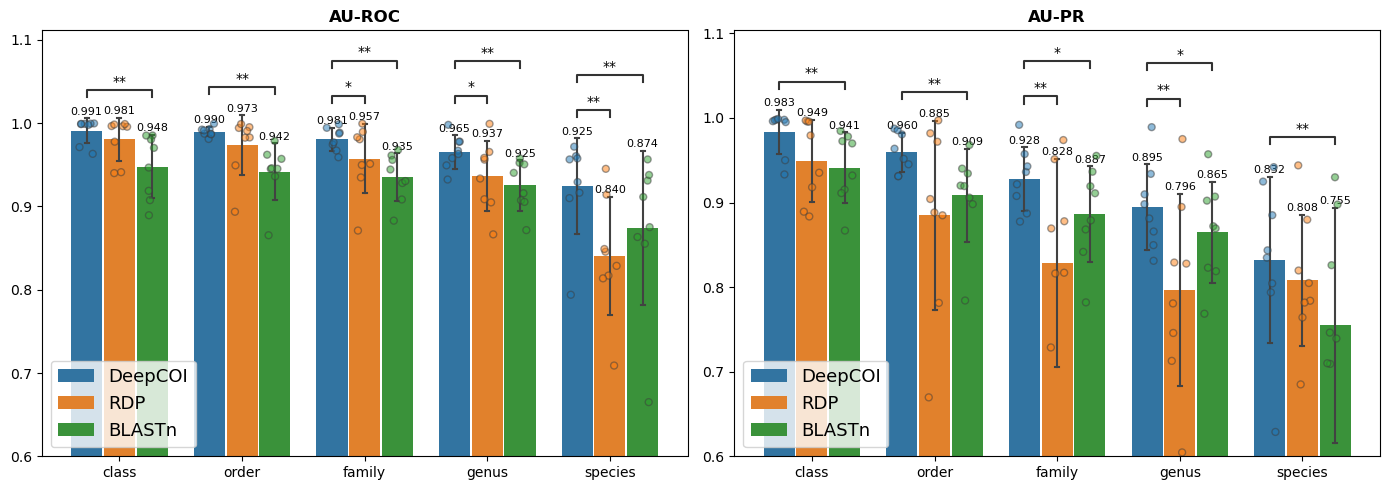

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0] = sns.barplot(data=df,
    x='rank', y='AUROC',
    hue='method',
    errorbar='sd', capsize=0.1,
    err_kws={'linewidth': 1.5},
    gap=.05,
    ax=ax[0]
)
ax[0].set_ylim((0.6, 1.02))

# Get bar heights and centers
bar_heights = [p.get_height() for p in ax[0].patches]
bar_centers = [p.get_x() + p.get_width() / 2.0 for p in ax[0].patches]

# Add annotations with offset
for i, (height, margin) in enumerate(zip(bar_heights, roc_std)):
    ax[0].text(bar_centers[i], height + margin + 0.002, f'{height:.3f}',  # Adjust offset (0.25) as needed
            ha='center', va='bottom', size=8)
sns.move_legend(ax[0], loc='lower left', fontsize=13)
ax[0].get_legend().set_title(None)

ax[0] = sns.stripplot(data=df,
    x='rank', y='AUROC', 
    hue='method', alpha=0.5,
    jitter=0.2, linewidth=1,
    dodge=True, size=5,
    ax=ax[0], 
    legend=False
)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_title("AU-ROC", fontweight='bold')

# add stat annots
annotator = Annotator(ax[0], roc_pairs, data=df, x='rank', y='AUROC', hue='method')
annotator.configure(test='Wilcoxon', text_format='star')
annotator.apply_and_annotate()


ax[1] = sns.barplot(data=df,
    x='rank', y='AUPR',
    hue='method',
    errorbar='sd', capsize=0.1,
    err_kws={'linewidth': 1.5},
    gap=.05,
    ax=ax[1]
)
ax[1].set_ylim((0.6, 1.02))

# Get bar heights and centers
bar_heights = [p.get_height() for p in ax[1].patches]
bar_centers = [p.get_x() + p.get_width() / 2.0 for p in ax[1].patches]

# Add annotations with offset
for i, (height, margin) in enumerate(zip(bar_heights, pr_std)):
    ax[1].text(bar_centers[i], height + margin + 0.002, f'{height:.3f}',  # Adjust offset (0.25) as needed
            ha='center', va='bottom', size=8)
sns.move_legend(ax[1], loc='lower left', fontsize=13)
ax[1].get_legend().set_title(None)

ax[1] = sns.stripplot(data=df,
    x='rank', y='AUPR', 
    hue='method', alpha=0.5,
    jitter=0.2, linewidth=1,
    dodge=True, size=5,
    ax=ax[1], 
    legend=False
)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_title("AU-PR", fontweight='bold')

# add stat annots
annotator = Annotator(ax[1], pr_pairs, data=df, x='rank', y='AUPR', hue='method')
annotator.configure(test='Wilcoxon', text_format='star')
annotator.apply_and_annotate()

fig.tight_layout()

In [13]:
fig.figure.savefig("../Figures/Figure3.pdf", format='pdf', bbox_inches='tight')

# Supplementary Figure S3

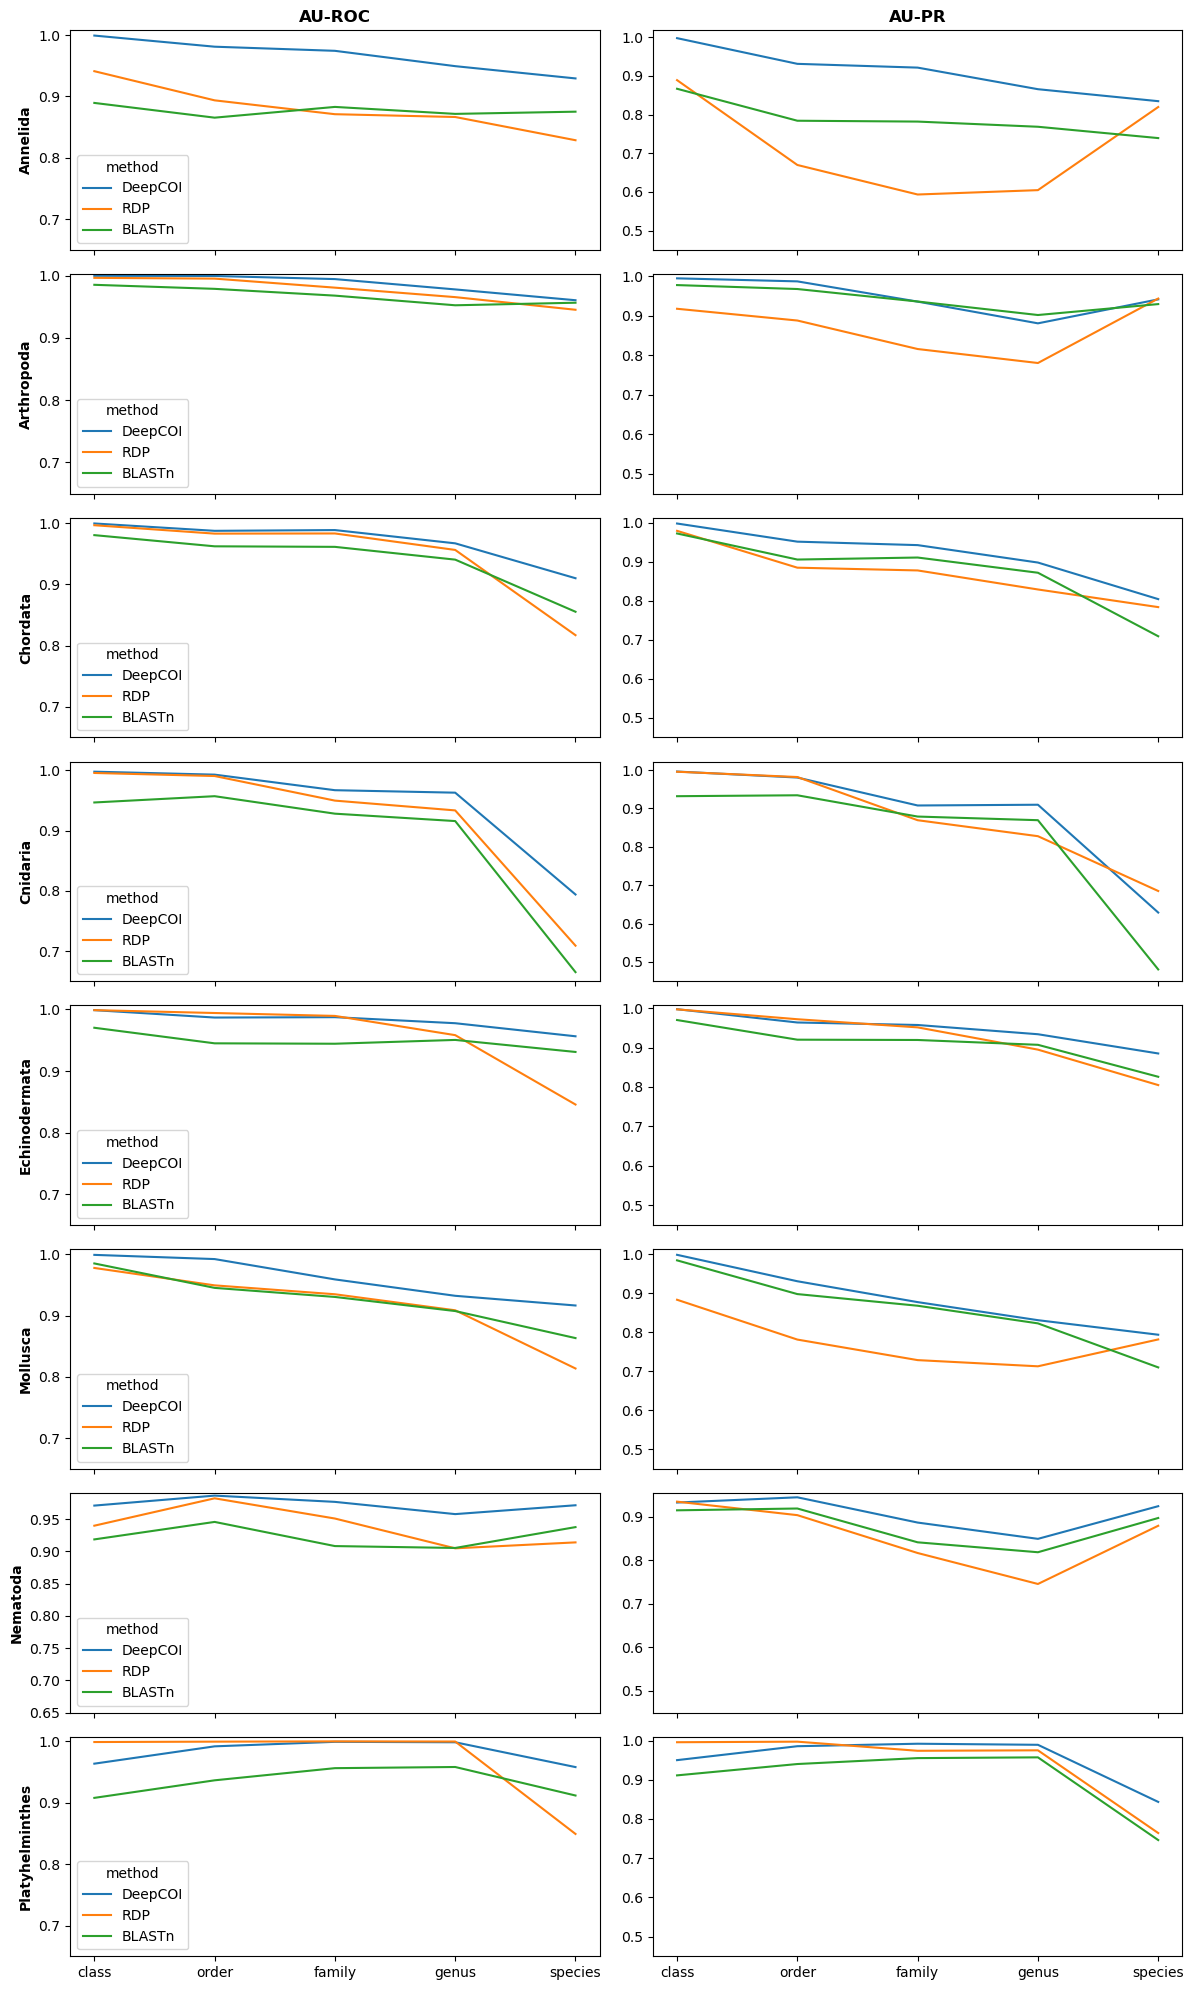

In [19]:
fig, ax = plt.subplots(8, 2, figsize=(12, 20), sharex=True)

for i, phylum in enumerate(PHYLA):
    ax[i, 0] = sns.lineplot(
        data=df.query('phylum == @phylum'),
        x='rank', y='AUROC',
        hue='method',
        ax=ax[i, 0]
    )
    ax[i, 0].set_xlabel(None)
    ax[i, 0].set_ylabel(phylum, fontweight='bold')
    ax[i, 0].set_ylim(bottom=0.65)
    if i == 0:
        ax[i, 0].set_title("AU-ROC", fontweight='bold')

    ax[i, 1] = sns.lineplot(
        data=df.query('phylum == @phylum'),
        x='rank', y='AUPR',
        hue='method',
        ax=ax[i, 1],
        legend=False,
    )
    ax[i, 1].set_xlabel(None)
    ax[i, 1].set_ylabel(None)
    ax[i, 1].set_ylim(bottom=0.45)
    if i == 0:
        ax[i, 1].set_title("AU-PR", fontweight='bold')

fig.tight_layout()

In [21]:
fig.figure.savefig("../Figures/Sup_Fig_S3.pdf", format='pdf', bbox_inches='tight')

# Supplementary Figure S4

In [22]:
df = pd.read_csv("excluded.csv", sep=',')
df['phylum'] = pd.Categorical(df['phylum'], ordered=True, categories=PHYLA)
df['rank'] = pd.Categorical(df['rank'], ordered=True, categories=RANKS[:-1])
df = df.sort_values(['rank', 'phylum'])

In [23]:
roc_std, pr_std = [], []
for method in ["DeepCOI", 'RDP', 'BLASTn']:
    roc_std.append(df.query("method == @method").groupby('rank')['AUROC'].std().values)
    pr_std.append(df.query("method == @method").groupby('rank')['AUPR'].std().values)
roc_std = np.concatenate(roc_std)
pr_std = np.concatenate(pr_std)

In [24]:
roc_pairs, pr_pairs = [], []
for rank in RANKS[:-1]:
    for method in ['RDP', 'BLASTn']:
        stats = wilcoxon(
            df.query("method == 'DeepCOI' and rank == @rank")['AUROC'],
            df.query("method == @method and rank == @rank")['AUROC']
        )

        if stats.pvalue < 0.05:
            roc_pairs.append(((rank, 'DeepCOI'), (rank, method)))
            
for rank in RANKS[:-1]:
    for method in ['RDP', 'BLASTn']:
        stats = wilcoxon(
            df.query("method == 'DeepCOI' and rank == @rank")['AUPR'],
            df.query("method == @method and rank == @rank")['AUPR']
        )
        
        if stats.pvalue < 0.05:
            pr_pairs.append(((rank, 'DeepCOI'), (rank, method)))

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

genus_DeepCOI vs. genus_RDP: Wilcoxon test (paired samples), P_val:2.344e-02 Stat=2.000e+00
order_DeepCOI vs. order_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
family_DeepCOI vs. family_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
genus_DeepCOI vs. genus_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
class_DeepCOI vs. class_BLASTn: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

family_DeepCOI vs. family_RDP: Wilcoxon test (paired samples), P_val:1.562e-02 Stat=1.000e+00
genus_DeepCOI vs. genus_RDP: Wilcoxon test (pair

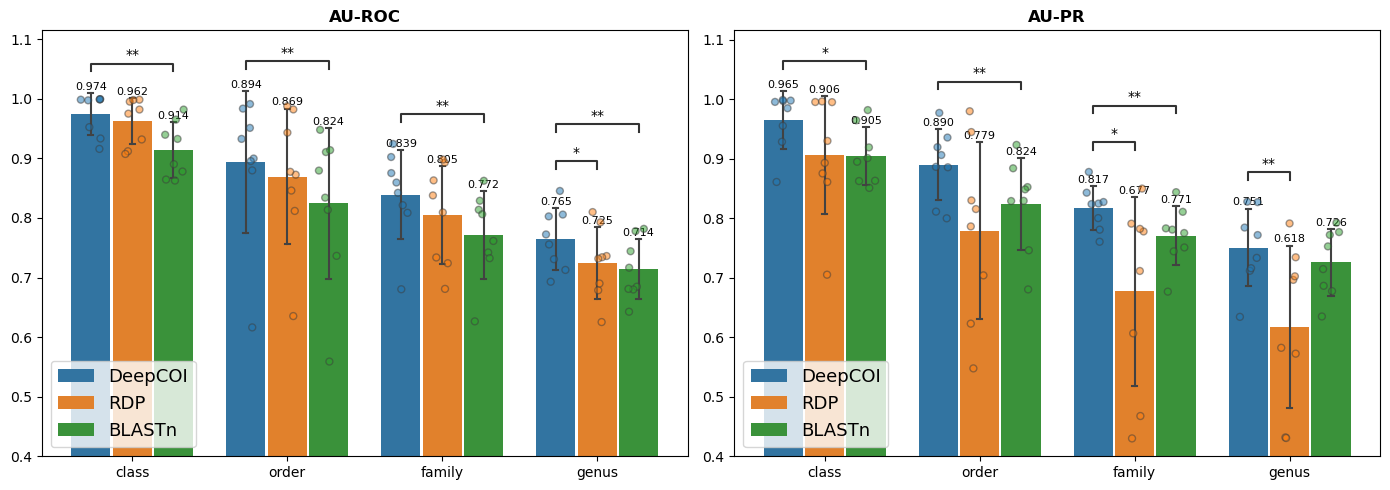

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0] = sns.barplot(data=df,
    x='rank', y='AUROC',
    hue='method',
    errorbar='sd', capsize=0.1,
    err_kws={'linewidth': 1.5},
    gap=.05,
    ax=ax[0]
)
ax[0].set_ylim((0.4, 1.02))

# Get bar heights and centers
bar_heights = [p.get_height() for p in ax[0].patches]
bar_centers = [p.get_x() + p.get_width() / 2.0 for p in ax[0].patches]

# Add annotations with offset
for i, (height, margin) in enumerate(zip(bar_heights, roc_std)):
    ax[0].text(bar_centers[i], height + margin + 0.002, f'{height:.3f}',  # Adjust offset (0.25) as needed
            ha='center', va='bottom', size=8)
sns.move_legend(ax[0], loc='lower left', fontsize=13)
ax[0].get_legend().set_title(None)

ax[0] = sns.stripplot(data=df,
    x='rank', y='AUROC', 
    hue='method', alpha=0.5,
    jitter=0.2, linewidth=1,
    dodge=True, size=5,
    ax=ax[0], 
    legend=False
)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_title("AU-ROC", fontweight='bold')

# add stat annots
annotator = Annotator(ax[0], roc_pairs, data=df, x='rank', y='AUROC', hue='method')
annotator.configure(test='Wilcoxon', text_format='star')
annotator.apply_and_annotate()


ax[1] = sns.barplot(data=df,
    x='rank', y='AUPR',
    hue='method',
    errorbar='sd', capsize=0.1,
    err_kws={'linewidth': 1.5},
    gap=.05,
    ax=ax[1]
)
ax[1].set_ylim((0.4, 1.02))

# Get bar heights and centers
bar_heights = [p.get_height() for p in ax[1].patches]
bar_centers = [p.get_x() + p.get_width() / 2.0 for p in ax[1].patches]

# Add annotations with offset
for i, (height, margin) in enumerate(zip(bar_heights, pr_std)):
    ax[1].text(bar_centers[i], height + margin + 0.002, f'{height:.3f}',  # Adjust offset (0.25) as needed
            ha='center', va='bottom', size=8)
sns.move_legend(ax[1], loc='lower left', fontsize=13)
ax[1].get_legend().set_title(None)

ax[1] = sns.stripplot(data=df,
    x='rank', y='AUPR', 
    hue='method', alpha=0.5,
    jitter=0.2, linewidth=1,
    dodge=True, size=5,
    ax=ax[1], 
    legend=False
)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_title("AU-PR", fontweight='bold')

# add stat annots
annotator = Annotator(ax[1], pr_pairs, data=df, x='rank', y='AUPR', hue='method')
annotator.configure(test='Wilcoxon', text_format='star')
annotator.apply_and_annotate()

fig.tight_layout()

In [26]:
fig.figure.savefig("../Figures/Sup_Fig_S4.pdf", format='pdf', bbox_inches='tight')